# U-net type encoder-decoder convolutional neural network

## Create a U-net type encoder-decoder CNN in Keras

### Import required Python libraries



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, UpSampling2D 
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.optimizers import Adam
import cv2

### Define helper functions

In [2]:
def image_stack_blur(image_stack, sigma_x, sigma_y):
    
    image_size = image_stack.shape[1] * image_stack.shape[2]
    img = []
    
    for i in range(len(image_stack)):
        
        img.append(cv2.GaussianBlur(image_stack[i], ksize=(0,0), sigmaX=sigma_x, sigmaY=sigma_y))
    
    img = np.array(img)
    img = img.reshape(len(img), image_size, 1)
    
    return(img)

### Import, process, and shape the dataset

* Importing data *

train :  (60000, 28, 28)
train_class :  (60000,)
test :  (10000, 28, 28)
test_class :  (10000,)

* one-hot enconding of class

train_class_onehot :  (60000, 10)
test_class_onehot :  (10000, 10)

class_names :  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

* processing and shaping data

input_train :  (60000, 28, 28, 1)
output_train :  (60000, 28, 28, 1)
input_test :  (10000, 28, 28, 1)
output_test :  (10000, 28, 28, 1)

* plot example from training set

item_id :  5
train_class [item_id] :  2
train_class_onehot [item_id] :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]



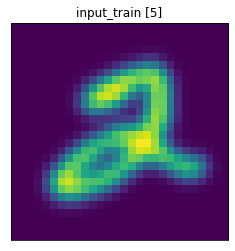

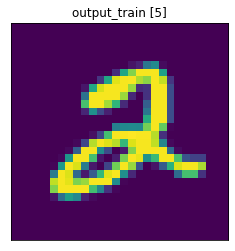

In [3]:
# import data from tensoforflow database

mnist = tf.keras.datasets.mnist  # load mnist dataset from tensorflow
(train, train_class), (test, test_class) = mnist.load_data()

print('* Importing data *')
print()
print('train : ', train.shape)
print('train_class : ', train_class.shape)
print('test : ', test.shape)
print('test_class : ', test_class.shape)
print()

# create one-hot encoded class

train_class_onehot = tf.keras.utils.to_categorical(train_class, 10)  
test_class_onehot = tf.keras.utils.to_categorical(test_class, 10)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']    # class names string

print('* one-hot enconding of class')
print()
print('train_class_onehot : ', train_class_onehot.shape)
print('test_class_onehot : ', test_class_onehot.shape)
print()
print('class_names : ', class_names)
print()

# Processing and shaping data
# input  : blurred image
# output : clean image

sigma_x = 1  # Gaussian blurring  kernel width
sigma_y = 1

output_train = train
input_train = image_stack_blur(train, sigma_x, sigma_y)
output_test = test
input_test = image_stack_blur(test, sigma_x, sigma_y)

input_train= input_train.reshape(input_train.shape[0], 28, 28, 1)  # add an extra dimension to array
output_train= output_train.reshape(output_train.shape[0], 28, 28, 1)
input_test= input_test.reshape(input_test.shape[0], 28, 28, 1)
output_test= output_test.reshape(output_test.shape[0], 28, 28, 1)

input_train = input_train / 255.0  # max normalise the image data[0:1]
output_train = output_train / 255.0 
input_test = input_test / 255.0
output_test = output_test / 255.0

print('* processing and shaping data')
print()
print('input_train : ', input_train.shape)
print('output_train : ', output_train.shape)
print('input_test : ', input_test.shape)
print('output_test : ', output_test.shape)
print()

# plot example

item_id = 5

print('* plot example from training set')
print()
print('item_id : ', item_id)
print('train_class [item_id] : ', train_class[item_id])
print('train_class_onehot [item_id] : ', train_class_onehot[item_id, :])
print()

plt.imshow(input_train[item_id, :, :, 0], cmap='viridis')
plt.title('input_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(output_train[item_id, :, :, 0], cmap='viridis')
plt.title('output_train [' + str(item_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

### Define the network hyperparameters

In [4]:
optimizer_type = Adam(lr=1e-4)  # optimisation algorithm: Adam 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error']  # network accuracy metric to be determined after each epoch
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 500   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Define the network architecture

* using the Keras' *functional* model


In [5]:
input_shape = (28, 28, 1)
inputs = Input(shape=input_shape)

# encoder section

down0 = Conv2D(32, (3, 3), padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv2D(32, (3, 3), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    
down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    
# center section
    
center = Conv2D(256, (3, 3), padding='same')(down1_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(256, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
    
# decoder section with skip connections to the encoder section

up1 = UpSampling2D((2, 2))(center)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)

outputs = Conv2D(1, (1, 1), activation='relu')(up0)

### Compile the network

In [6]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()


* Compiling the network model *

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 28, 28, 32)   0      

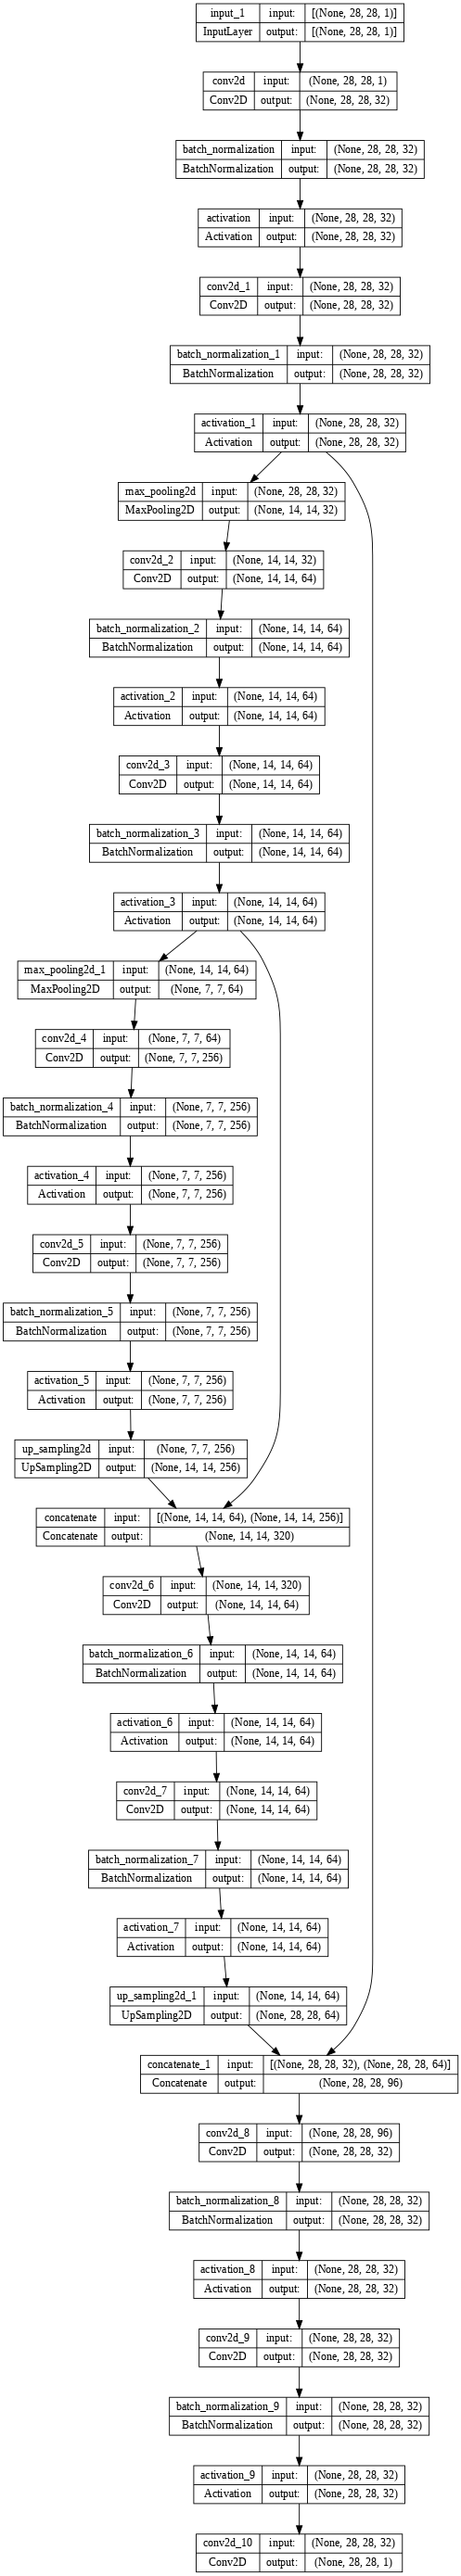

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Train the neural network with the training dataset

In [8]:
print('* Training the compiled network *')
print()

history = model.fit(input_train, output_train, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)

print()
print('Training completed')
print()

* Training the compiled network *

Epoch 1/20
96/96 [==============================] - 24s 147ms/step - loss: 0.2084 - mean_absolute_error: 0.2734 - val_loss: 0.0873 - val_mean_absolute_error: 0.1818
Epoch 2/20
96/96 [==============================] - 13s 131ms/step - loss: 0.0098 - mean_absolute_error: 0.0395 - val_loss: 0.0885 - val_mean_absolute_error: 0.1467
Epoch 3/20
96/96 [==============================] - 13s 136ms/step - loss: 0.0063 - mean_absolute_error: 0.0294 - val_loss: 0.0706 - val_mean_absolute_error: 0.1181
Epoch 4/20
96/96 [==============================] - 13s 132ms/step - loss: 0.0047 - mean_absolute_error: 0.0248 - val_loss: 0.0416 - val_mean_absolute_error: 0.0855
Epoch 5/20
96/96 [==============================] - 13s 133ms/step - loss: 0.0039 - mean_absolute_error: 0.0221 - val_loss: 0.0181 - val_mean_absolute_error: 0.0531
Epoch 6/20
96/96 [==============================] - 13s 137ms/step - loss: 0.0034 - mean_absolute_error: 0.0203 - val_loss: 0.0074 - val_mea

### Plot the training history of the network

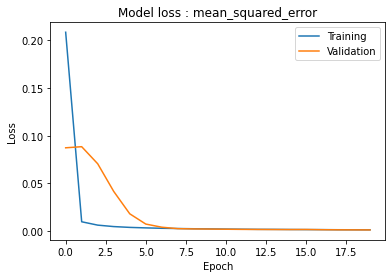

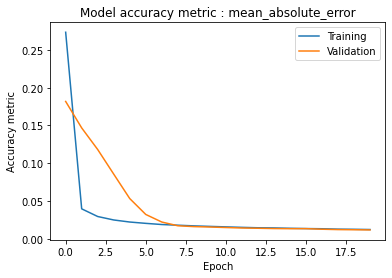

In [9]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

### Evaluate the trained network performance on the unseen test dataset

In [10]:
print('* Evaluating the performance of the trained network on the unseen test dataset *')
print()

evaluate_model = model.evaluate(x=input_test, y=output_test)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.6f'%loss_metric)

* Evaluating the performance of the trained network on the unseen test dataset *

313/313 [==============================] - 2s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0117

Accuracy - mean_absolute_error: 0.012
Loss - mean_squared_error: 0.001260


### Predict the output of a given input

* Predicting the output of a given input from test set *

1/1 [==============================] - 0s 341ms/step
test_id :  32



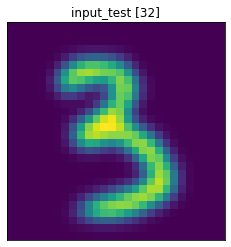

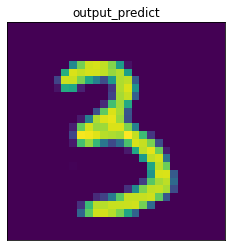

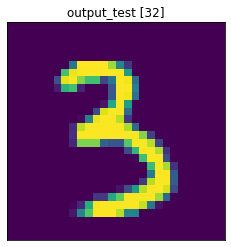

In [11]:
print('* Predicting the output of a given input from test set *')
print()

test_id = 32

input_predict = np.zeros(shape=(1, 28, 28, 1))  # create numpy array of required dimensions for network input

input_predict[0, :, :, 0] = input_test[test_id, :, :, 0]  # reshaping test input image

output_predict = model.predict(input_predict)


print('test_id : ', test_id)
print()

# plot prediction example from test set

plt.imshow(input_test[test_id, :, :, 0], cmap='viridis')
plt.title('input_test [' + str(test_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

print()

plt.imshow(output_predict[0, :, :, 0], cmap='viridis')
plt.title('output_predict')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

print()

plt.imshow(output_test[test_id, :, :, 0], cmap='viridis')
plt.title('output_test [' + str(test_id) + ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

